In [1]:
import numpy as np
import tensorflow as tf
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

#Physical constants and parameters
r = 10 ** -3
Mu = 4 * np.pi * 10 ** -7
V = (4 / 3) * np.pi * r ** 3
m = 2 * 10 ** -19
kB = 1.3806488 * 10 ** -23
Ms = 23.5 * 10 ** 3
T = 300
Visc = 50

L = 1E-3

In [3]:
#Magnetic force as a function of distance x
def FM(x):

    coth = lambda x: 1 / np.tanh(x)

    #Polynomial fit for magnetic field strength H(x)
    a5, a4, a3, a2, a1, a0 = (
        -2.5573e13, 2.5005e12, -9.538e10, 1.7906e9, -1.699e7, 69605.5
    )
    Hs = a5 * x**5 + a4 * x**4 + a3 * x**3 + a2 * x**2 + a1 * x + a0
    abs_Hs = np.abs(Hs)

    #Langevin function approximation for magnetization
    coth_term = coth((Mu * m / (kB * T)) * abs_Hs)
    Mfit = Ms * (coth_term - (kB * T) / (Mu * m * abs_Hs)) * Hs / abs_Hs

    #Derivative of H(x) with respect to x
    DH = 5 * a5 * x**4 + 4 * a4 * x**3 + 3 * a3 * x**2 + 2 * a2 * x + a1

    #Magnetic force expression
    Fmx = -(V * Mu) * Mfit * DH

    return Fmx

#Numerical computation of ODE for the calculation of traversal time
def compute_time(z, r, Visc):
    time, _ = quad(lambda x: (6 * np.pi * r * Visc / FM(x)), 0, z)
    return time

In [4]:
eq = lambda z: compute_time(z, r, Visc)

#Generate training data
x_train = np.linspace(0.015, 0.02, 4).reshape(-1, 1)
t_train = np.array(np.array([eq(xi) for xi in x_train]) + np.random.normal(0, 200, 4)).reshape(-1, 1) #Introduce Gaussian noise

#Scale data for training
x_train_scaled = x_train / L
t_train_scaled = (np.log(t_train)).reshape(-1, 1)

x_train_tf = tf.convert_to_tensor(x_train_scaled, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train_scaled, dtype=tf.float32)

In [5]:
#Define nueral network architecture
class Net(tf.keras.Model):
    def __init__(self, n_units=100):
        super(Net, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(n_units, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(n_units, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(n_units, activation='relu')
        self.hidden_4 = tf.keras.layers.Dense(n_units, activation='relu')
        self.out = tf.keras.layers.Dense(1, activation = None)


    def call(self, x):
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.hidden_3(x)
        x = self.hidden_4(x)
        return self.out(x)

#Physics-informed loss function
def physics_loss(model):
  x = np.linspace(0.0, 0.02, 1000).reshape(-1, 1)
  ode = 6 * np.pi * r * Visc / FM(x)

  #Normalize input
  x = x / L
  x = tf.convert_to_tensor(x, dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(x)
    pred = model(x)
    dT = tape.gradient(pred, x)

  #Residual of the governing equation
  pde_residual = ode - (np.exp(pred)/L)*dT
  return tf.reduce_mean(tf.square(pde_residual))

In [6]:
#Training loop utilizing combined data loss and physics loss
def train_model(model, x_train, y_train, epochs=10000, lr=1e-4, loss_weight=1e0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(x_train)
            data_loss = tf.reduce_mean(tf.square(y_pred - y_train))
            phys_loss = physics_loss(model)
            total_loss = data_loss + loss_weight * phys_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.numpy()}, Data Loss: {data_loss.numpy()}, Physics Loss: {phys_loss.numpy()}")

In [7]:
#Train the PINN model
pinn_model = Net(n_units=100)
train_model(pinn_model, x_train_tf, t_train_tf, epochs=4000)

Epoch 0, Loss: 116444413952.0, Data Loss: 59.60179138183594, Physics Loss: 116444413952.0
Epoch 50, Loss: 94872371200.0, Data Loss: 6.195950508117676, Physics Loss: 94872371200.0
Epoch 100, Loss: 7354418176.0, Data Loss: 0.42423275113105774, Physics Loss: 7354418176.0
Epoch 150, Loss: 7202664448.0, Data Loss: 0.4358408451080322, Physics Loss: 7202664448.0
Epoch 200, Loss: 7132705280.0, Data Loss: 0.4244845509529114, Physics Loss: 7132705280.0
Epoch 250, Loss: 7044564992.0, Data Loss: 0.4163062572479248, Physics Loss: 7044564992.0
Epoch 300, Loss: 6948699136.0, Data Loss: 0.4079550802707672, Physics Loss: 6948699136.0
Epoch 350, Loss: 6847488000.0, Data Loss: 0.3991478681564331, Physics Loss: 6847488000.0
Epoch 400, Loss: 6741711360.0, Data Loss: 0.39001399278640747, Physics Loss: 6741711360.0
Epoch 450, Loss: 6632098304.0, Data Loss: 0.38061997294425964, Physics Loss: 6632098304.0
Epoch 500, Loss: 6519308288.0, Data Loss: 0.3710271716117859, Physics Loss: 6519308288.0
Epoch 550, Loss: 

In [8]:
#Generate test predictions
x_test = np.linspace(0.0, 0.02, 1000).reshape(-1, 1)
x_test_scaled = x_test/L
x_test_tf = tf.convert_to_tensor(x_test_scaled, dtype=tf.float32)

y_pred = pinn_model.predict(x_test_tf)
y_pred_rescaled = np.exp(y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


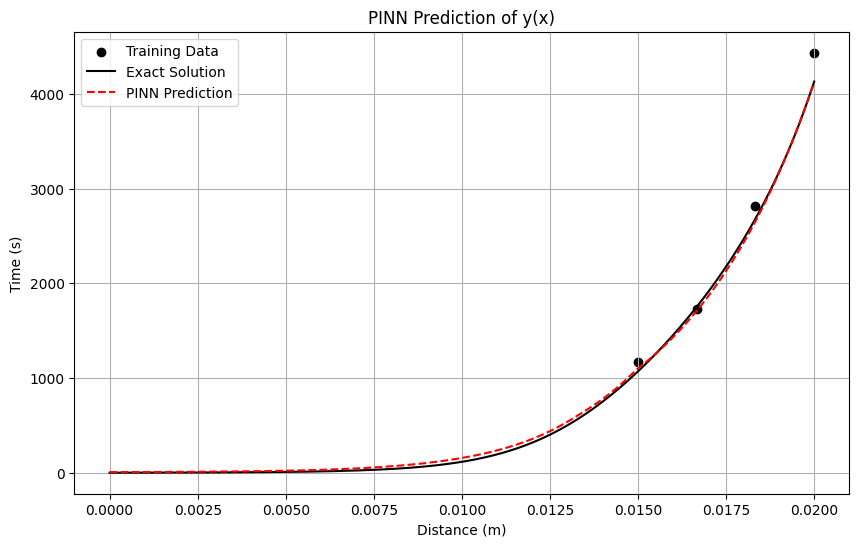

In [9]:
#Plot results
plt.figure(figsize=(10, 6))
plt.scatter(x_train, t_train, color='black', label='Training Data')
plt.plot(x_test, np.array([eq(xi) for xi in x_test]), 'k', label='Exact Solution')
plt.plot(x_test, y_pred_rescaled, '--r', label='PINN Prediction')
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)
plt.title('PINN Prediction of y(x)')
plt.show()